# Mouse MPC KO Analysis
Analysis: [Jordan A. Berg](https://github.com/j-berg)   
Sample Preparation:   
Manuscript Lead Author: Ahmad Cluntun

### Import libraries for analysis

In [1]:
__path__ = "./"
gtf_file = "~/Desktop/Mus_musculus.GRCm38.100.gtf.gz"

import pandas as pd 
import numpy as np
from sklearn import preprocessing
import xpressplot as xp 

import matplotlib
%matplotlib inline

## Import RNA-Seq count data
- `counts_0730.txt` and `counts_0807.txt` are the same samples sequenced twice. These counts will be combined 

In [2]:
# 8 wk
data_8wk = pd.read_csv(
     __path__ + "data/counts_0924.txt",
    sep='\t',
    index_col=0
)
data_8wk.index.name = None
data_8wk = data_8wk.drop('15948X19', axis=1)

# 16 wk
data1 = pd.read_csv(
     __path__ + "data/counts_0730.txt",
    sep='\t',
    index_col=0
)
data1.index.name = None

data2 = pd.read_csv(
     __path__ + "data/counts_0807.txt",
    sep='\t',
    index_col=0
)
data2.index.name = None

data_16wk = pd.concat([data1, data2], axis=1)
data_16wk = data_16wk.groupby(data_16wk.columns, axis=1).sum()

### Remove rRNA

In [3]:
def remove_rrna(
        data, 
        rrna_list):
    
    data_c = data.copy()
    
    for x in rrna_list:

        if x in data_c.index.tolist():
            data_c.drop(x, inplace=True)
            
    return data_c

In [4]:
gtf = pd.read_csv( 
    gtf_file,
    sep='\t',
    header=None,
    comment='#',
    low_memory=False
)

rrna = gtf.loc[
    (gtf[2] == "gene")
    & (gtf[8].str.contains("rRNA"))
]

rrna_l = []

for index, row in rrna.iterrows():

    rrna_l.append(row[8].split('gene_id \"')[1].split('\"')[0])

In [5]:
print(data_8wk.shape)

data_8wk = remove_rrna(data_8wk, rrna_l)

print(data_8wk.shape)

(55536, 9)
(55180, 9)


In [6]:
print(data_16wk.shape)

data_16wk = remove_rrna(data_16wk, rrna_l)

print(data_16wk.shape)

(55536, 10)
(55180, 10)


In [7]:
print('8wk:', data_8wk.loc['ENSMUSG00000024158'].min())
print('16wk:', data_16wk.loc['ENSMUSG00000024158'].min())

8wk: 492
16wk: 72


### Check minimum threshold to maintain Mpc1 (the target KO in the experiment)
- Set thresholds at the minimum cutoff and remove any row with over a million counts

In [8]:
print('8wk:', data_8wk.loc['ENSMUSG00000023861'].min())
print('16wk:', data_16wk.loc['ENSMUSG00000023861'].min())

8wk: 200
16wk: 96


In [9]:
data_8wk_threshold = data_8wk.loc[
    (data_8wk[data_8wk.columns.tolist()].max(axis=1) >= 95)
    & (data_8wk[data_8wk.columns.tolist()].max(axis=1) < 1e6)
]

data_8wk_threshold.shape

(11067, 9)

In [10]:
data_16wk_threshold = data_16wk.loc[
    (data_16wk[data_16wk.columns.tolist()].max(axis=1) >= 95)
    & (data_16wk[data_16wk.columns.tolist()].max(axis=1) < 1e6)
]

data_16wk_threshold.shape

(10974, 10)

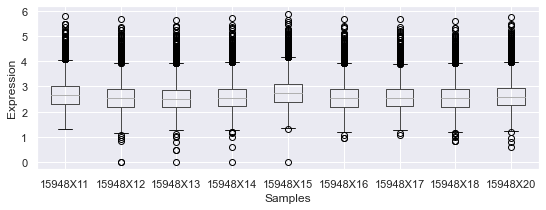

In [11]:
xp.check_samples(np.log10(data_8wk_threshold + 1))

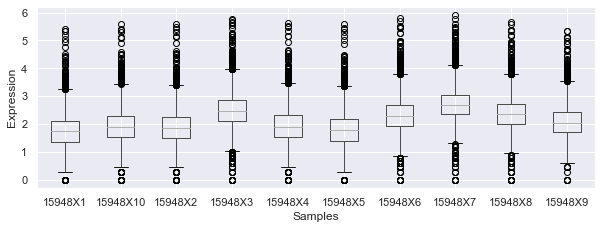

In [12]:
xp.check_samples(np.log10(data_16wk_threshold + 1))

### Convert gene ids to gene names and normalize
- Using `Mus musculus build GRCm38 release 100`

In [13]:
# 8wk
data_8wk_threshold = xp.convert_names( 
    data_8wk_threshold, 
    gtf_file, 
    orig_name_label='gene_id "', 
    orig_name_location=0, 
    new_name_label='gene_name "', 
    new_name_location=2
)

# 16wk
data_16wk_threshold = xp.convert_names( 
    data_16wk_threshold, 
    gtf_file, 
    orig_name_label='gene_id "', 
    orig_name_location=0, 
    new_name_label='gene_name "', 
    new_name_location=2
)

In [14]:
# 8wk
data_8wk_norm = xp.r_fpkm(
    data_8wk_threshold,
    gtf_file,
    feature_type='exon',
    identifier='gene_name'
)

# 16wk
data_16wk_norm = xp.r_fpkm(
    data_16wk_threshold,
    gtf_file,
    feature_type='exon',
    identifier='gene_name'
)

~/Desktop/Mus_musculus.GRCm38.100.gtf.gz does not appear to be a GTF file
~/Desktop/Mus_musculus.GRCm38.100.gtf.gz does not appear to be a GTF file


In [15]:
# Output 
data_8wk_norm.to_csv(
    __path__ + 'data/8wk_normed.tsv',
    sep='\t')

data_16wk_norm.to_csv(
    __path__ + 'data/16wk_normed.tsv',
    sep='\t')

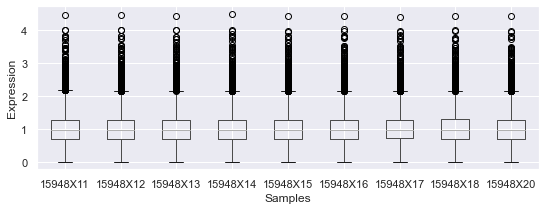

In [16]:
xp.check_samples(np.log10(data_8wk_norm + 1))

In [17]:
data_8wk_norm.median()

15948X11    8.247463
15948X12    8.306779
15948X13    8.198091
15948X14    8.266701
15948X15    8.337131
15948X16    8.182587
15948X17    8.517658
15948X18    8.510025
15948X20    8.249909
dtype: float64

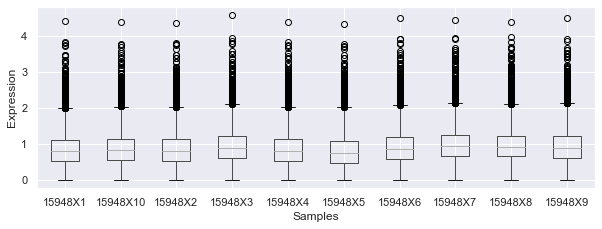

In [18]:
xp.check_samples(np.log10(data_16wk_norm + 1))

In [19]:
data_16wk_norm.median()

15948X1     5.206172
15948X10    5.586507
15948X2     5.346684
15948X3     6.744851
15948X4     5.267296
15948X5     4.682647
15948X6     6.275211
15948X7     7.842610
15948X8     7.392870
15948X9     6.788766
dtype: float64

In [20]:
data_16wk_norm = data_16wk_norm[[
    '15948X1',
    '15948X2',
    '15948X3',
    '15948X4',
    '15948X5',
    '15948X6',
    '15948X7',
    '15948X8',
    '15948X9',
    '15948X10'
]]

### Scale data

In [21]:
data_8wk_scaled = data_8wk_norm.copy()
data_8wk_scaled[data_8wk_scaled.columns] = preprocessing.scale(data_8wk_scaled[data_8wk_scaled.columns], axis=1)

data_16wk_scaled = data_16wk_norm.copy()
data_16wk_scaled[data_16wk_scaled.columns] = preprocessing.scale(data_16wk_scaled[data_16wk_scaled.columns], axis=1)

## Analysis

In [22]:
meta_8wk = pd.DataFrame()
meta_8wk[0] = [
    '15948X11',
    '15948X12',
    '15948X13',
    '15948X14',
    '15948X15',
    '15948X16',
    '15948X17',
    '15948X18',
    '15948X20'
]
meta_8wk[1] = [
    'WT-8',
    'WT-8',
    'WT-8',
    'WT-8',
    'WT-8',
    'KO-8',
    'KO-8',
    'KO-8',
    'KO-8'
]

meta_16wk = pd.DataFrame()
meta_16wk[0] = [
    '15948X1',
    '15948X2',
    '15948X3',
    '15948X4',
    '15948X5',
    '15948X6',
    '15948X7',
    '15948X8',
    '15948X9',
    '15948X10'
]
meta_16wk[1] = [
    'WT-16',
    'WT-16',
    'WT-16',
    'WT-16',
    'WT-16',
    'KO-16',
    'KO-16',
    'KO-16',
    'KO-16',
    'KO-16'
]

### Pyruvate metabolism

In [23]:
pyru = pd.read_csv(__path__ + "gene_lists/pyruvate_list.csv", header=None)

In [24]:
pyru[0] = pyru[0].str.lower().str.capitalize()

In [25]:
gene_colors = {
    'acetyl-CoA related':'#a6cee3', 
    'Glycolysis':'#1f78b4', 
    'pyruvate dehydrogenase':'#b2df8a',
    'lactate related':'#33a02c',
    'lacate dehydrogenase':'#fb9a99',
    'Malic enzyme':'#e31a1c',
    'pyruvate carboxylase':'#fdbf6f',
    'pyruvate kinase':'#ff7f00',
    'pyruvate dehydrogenase kinase':'#cab2d6',
    'pyruvate transporter':'#6a3d9a',
    'lactate/pyruvate transporter':'#ffff99',
    'TCA Cycle':'#b15928',
    'Pyruvate-Alanine transaminase':'#000000'
}

In [26]:
pyru

,0,1
0,Acaca,acetyl-CoA related
1,Acacb,acetyl-CoA related
2,Acat1,acetyl-CoA related
3,Acat2,acetyl-CoA related
4,Acot12,acetyl-CoA related
...,...,...
75,Gpt2,Pyruvate-Alanine transaminase
76,Slc2a1,Glycolysis
77,Slc2a2,Glycolysis
78,Slc2a3,Glycolysis


<Figure size 432x288 with 0 Axes>

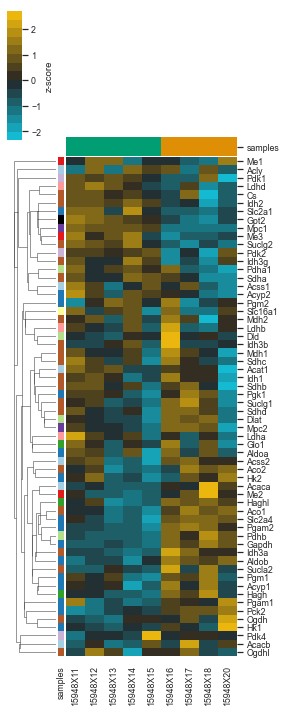

In [33]:
data_8wk_colors = {'KO-8': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'WT-8': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    gene_info=pyru,
    gene_palette=gene_colors,
    sample_palette=data_8wk_colors, 
    gene_list=pyru[0].tolist(), 
    figsize=(4,10), 
    save_fig=(__path__ + 'plots/mouse_8wks_pyruvate.pdf'),
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=True,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0)

Glycolysis and TCA cycle sub-groups start to cluster   
And both are actually more up-regulated

<Figure size 432x288 with 0 Axes>

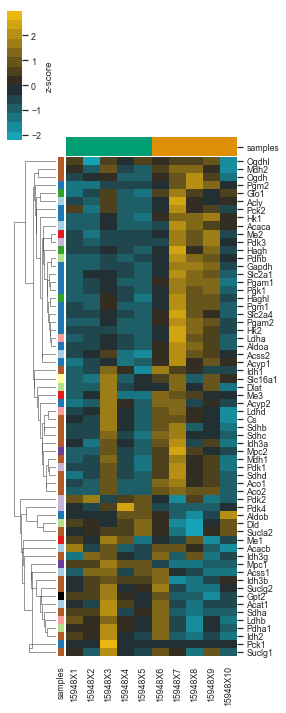

In [34]:
data_16wk_scaled = data_16wk_scaled[[
    '15948X1',
    '15948X2',
    '15948X3',
    '15948X4',
    '15948X5',
    '15948X6',
    '15948X7',
    '15948X8',
    '15948X9',
    '15948X10'
]]

data_16wk_colors = {'KO-16': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'WT-16': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    gene_info=pyru,
    gene_palette=gene_colors,
    sample_palette=data_16wk_colors, 
    gene_list=pyru[0].tolist(), 
    figsize=(4,10), 
    save_fig=(__path__ + 'plots/mouse_16wks_pyruvate.pdf'),
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=True,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0)

### Analyze list of genes that are up-regulated at 16 wks

In [35]:
genes = []

for index, row in data_16wk_scaled.iterrows():

    ko = data_16wk_scaled.loc[[index]].iloc[:,5:10].min(axis=1)[0]
    wt = data_16wk_scaled.loc[[index]].iloc[:,0:5].min(axis=1)[0]
    if ko > 0.1 and wt < -0.1:
        genes.append(index)

<Figure size 432x288 with 0 Axes>

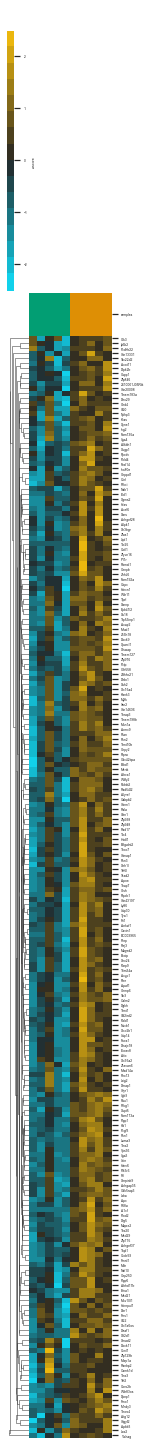

In [36]:
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=genes,
    figsize=(2,20), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wks_up.pdf')

### Analyze list of genes down-regulated at 16 wks

In [37]:
genes2 = []

for index, row in data_16wk_scaled.iterrows():

    ko = data_16wk_scaled.loc[[index]].iloc[:,5:10].max(axis=1)[0]
    wt = data_16wk_scaled.loc[[index]].iloc[:,0:5].max(axis=1)[0]
    if wt > 0.1 and ko < -0.1:
        genes2.append(index)

<Figure size 432x288 with 0 Axes>

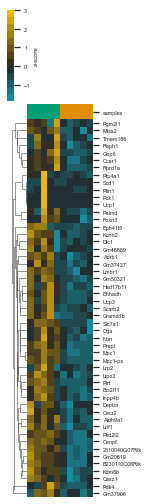

In [38]:
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=genes2,
    figsize=(2,7), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.5,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wks_up.pdf')

### Analyze hypertrophy gene set

In [39]:
genes3 = [
    'Mybpc3',
    'Des',
    'Cacnb1',
    'Ace',
    'Prkab2',
    'Tpm4',
    'Tgfb3',
    'Itga9',
    'Itgb5',
    'Tgfb2',
    'Itga5',
    'Actb',
    'Itga11',
    'Itgb3',
    'Itgb8',
    'Itgb4',
    'Cacnb4',
    'Itga6',
    'Cacng7',
    'Itga1',
    'Myh7',
    'Igf1',
    'Lmna',
    'Tpm2',
    'Itga2'
]

<Figure size 432x288 with 0 Axes>

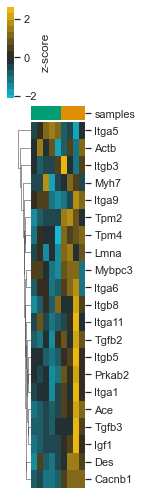

In [40]:
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=genes3,
    figsize=(2,7), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=1,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wks_hypertrophy.pdf')

<Figure size 432x288 with 0 Axes>

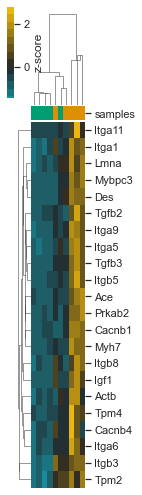

In [41]:
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=genes3,
    figsize=(2,7), 
    row_cluster=True, 
    col_cluster=True, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=1,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wks_hypertrophy.pdf')

### Metabolism gene set
- GO_0016491_oxoreductase_activity

In [42]:
oxo_red = pd.read_csv(
    __path__ + 'gene_lists/GO_0016491_oxoreductase_activity.csv')

<Figure size 432x288 with 0 Axes>

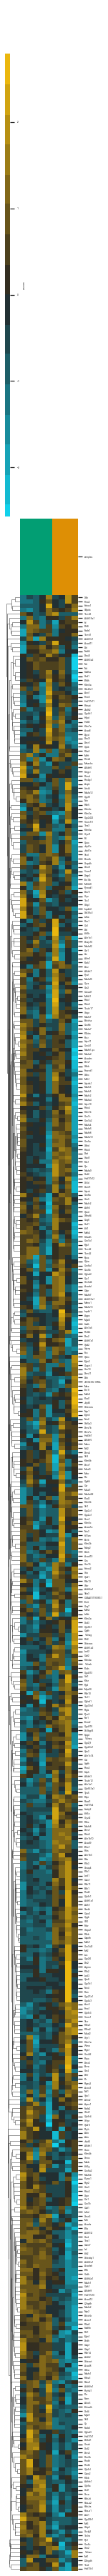

In [43]:
# 8wk
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=oxo_red.name.tolist(),
    figsize=(2,50), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wk_oxo_red.pdf')

<Figure size 432x288 with 0 Axes>

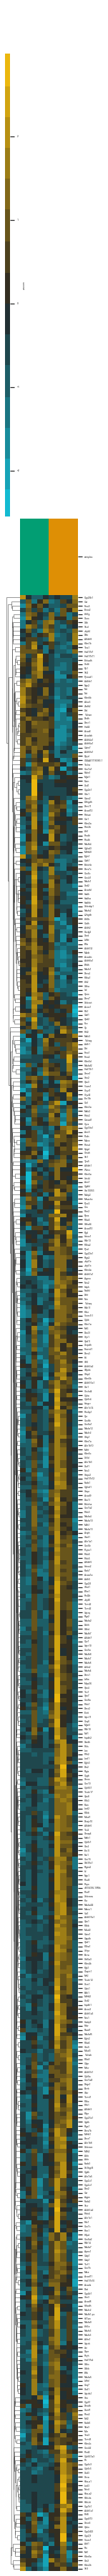

In [44]:
# 16wk
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=oxo_red.name.tolist(),
    figsize=(2,50),
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wk_oxo_red.pdf')

- GO_0019752_carboxylic_acid_mteabolic_process

In [45]:
carb_acid = pd.read_csv(
    __path__ + 'gene_lists/GO_0019752_carboxylic_acid_mteabolic_process.csv')

<Figure size 432x288 with 0 Axes>

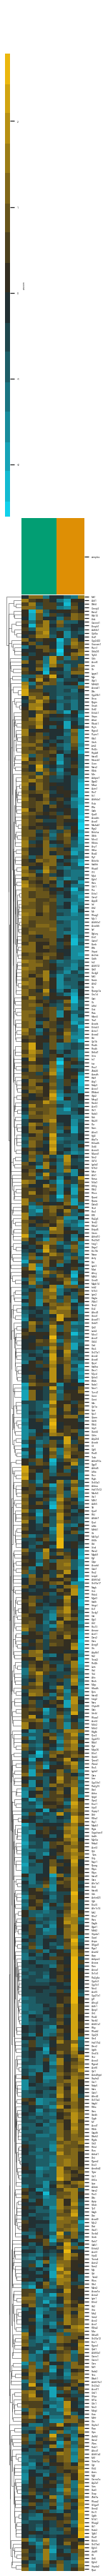

In [46]:
# 8wk
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=carb_acid.name.tolist(),
    figsize=(2,50), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wk_carb_acid.pdf')

<Figure size 432x288 with 0 Axes>

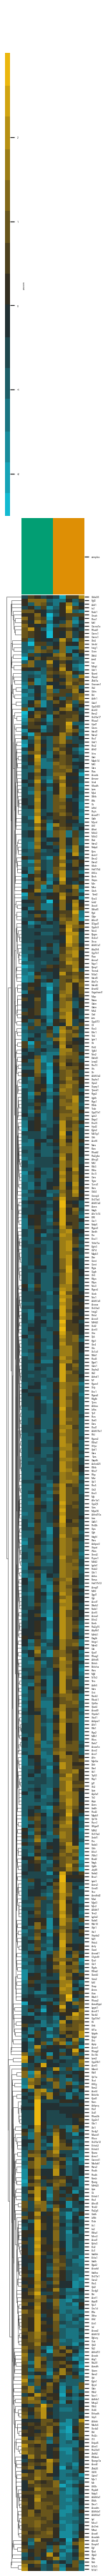

In [47]:
# 16wk
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=carb_acid.name.tolist(),
    figsize=(2,50),
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wk_carb_acid.pdf')

### Growth gene set
- GO_0009888_tissue_dev

In [48]:
tissue_dev = pd.read_csv(
    __path__ + 'gene_lists/GO_0009888_tissue_dev.csv')

<Figure size 432x288 with 0 Axes>

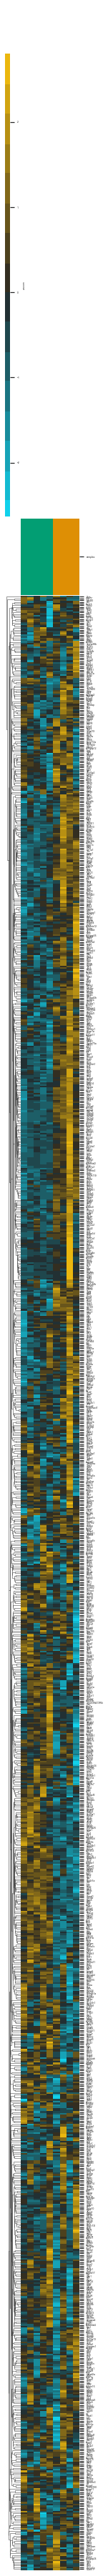

In [49]:
# growth
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=tissue_dev.name.tolist(),
    figsize=(2,50), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wk_tissue_dev.pdf')

<Figure size 432x288 with 0 Axes>

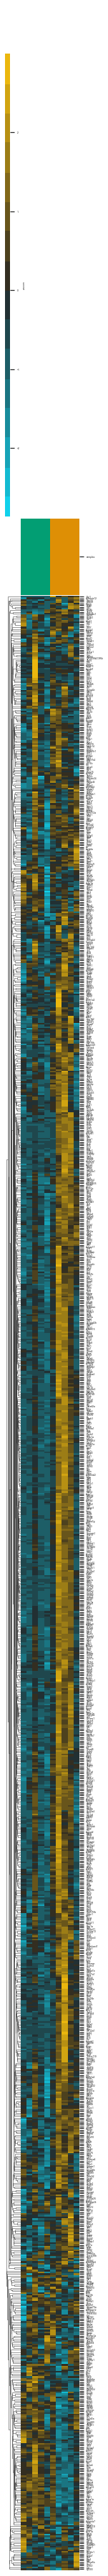

In [50]:
# growth
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=tissue_dev.name.tolist(),
    figsize=(2,50), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wk_tissue_dev.pdf')

- GO_0048407_platelet_growth

In [51]:
platelet_growth = pd.read_csv(
    __path__ + 'gene_lists/GO_0048407_platelet_growth.csv')

<Figure size 432x288 with 0 Axes>

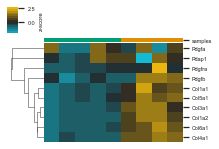

In [52]:
# growth
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=platelet_growth.name.tolist(),
    figsize=(3,2), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.5,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wk_platelet_growth.pdf')

<Figure size 432x288 with 0 Axes>

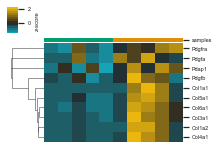

In [53]:
# growth
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=platelet_growth.name.tolist(),
    figsize=(3,2),
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.5,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wk_platelet_growth.pdf')

### Cardiogenensis gene set
- custom TF set

In [54]:
cardiogenesis = [
    'Actc1',
    'Nkx2-5',
    'Gata6',
    'Mef2c',
    'Tnnt2']

<Figure size 432x288 with 0 Axes>

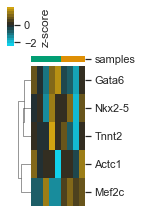

In [55]:
# 8wk
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=cardiogenesis,
    figsize=(2,3), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=1,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wks_cardiogenesis.pdf')

<Figure size 432x288 with 0 Axes>

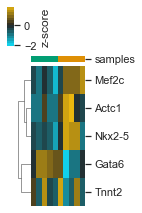

In [56]:
# 16wk
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=cardiogenesis,
    figsize=(2,3), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=1,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wks_cardiogenesis.pdf')

- Cardiovascular system development

In [57]:
cardio_dev = pd.read_csv(
    __path__ + 'gene_lists/GO_0072358_cardiovascular_sys_dev.csv')

<Figure size 432x288 with 0 Axes>

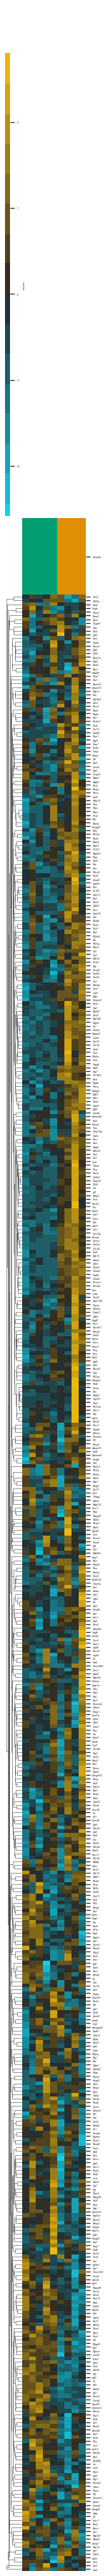

In [58]:
# 8wk
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=cardio_dev.name.tolist(),
    figsize=(2,50), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wks_cardio_dev.pdf')

<Figure size 432x288 with 0 Axes>

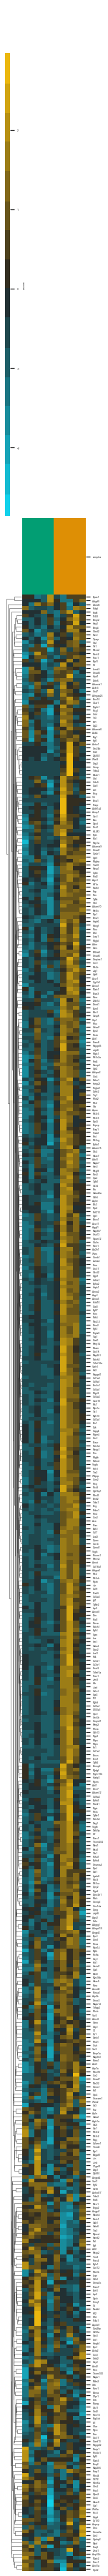

In [59]:
# 16wk
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=cardio_dev.name.tolist(),
    figsize=(2,50), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wks_cardio_dev.pdf')

### Signaling
- GO_0007166_cell_surface_receptor_signaling_pathway

In [60]:
recept = pd.read_csv(
    __path__ + 'gene_lists/GO_0007166_cell_surface_receptor_signaling_pathway.csv')

<Figure size 432x288 with 0 Axes>

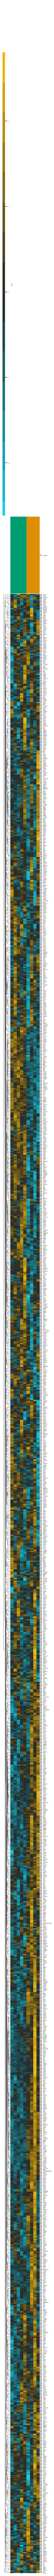

In [61]:
# 8wk
xp.heatmap(
    data_8wk_scaled, 
    meta_8wk, 
    sample_palette=data_8wk_colors, 
    gene_list=recept.name.tolist(),
    figsize=(2,100), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_8wks_recept.pdf')

<Figure size 432x288 with 0 Axes>

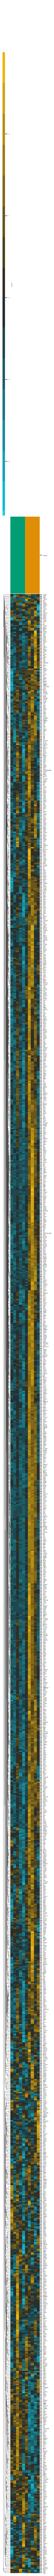

In [62]:
# 16wk
xp.heatmap(
    data_16wk_scaled, 
    meta_16wk, 
    sample_palette=data_16wk_colors, 
    gene_list=recept.name.tolist(),
    figsize=(2,100), 
    row_cluster=True, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    font_scale=0.3,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    save_fig=__path__ + 'plots/mouse_16wks_recept.pdf')

### Gene expression analysis
Some notes:
- Mct4 (Slc16a3) and Ass1 had low counts in all datasets

<Figure size 432x288 with 0 Axes>

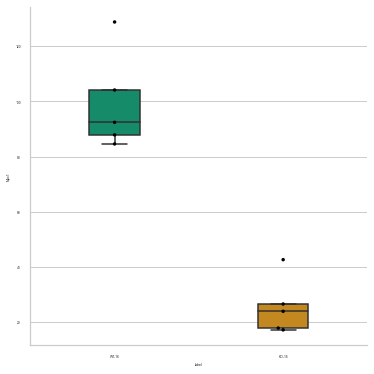

In [63]:
xp.gene_overview(
    data_16wk_norm, 
    meta_16wk, 
    gene_name='Mpc1',
    palette=data_16wk_colors, 
    order=['WT-16','KO-16'],
    save_fig=__path__ + 'plots/Mct4_boxswarm_16wk.pdf', 
    grid=True, 
    whitegrid=True)

<Figure size 432x288 with 0 Axes>

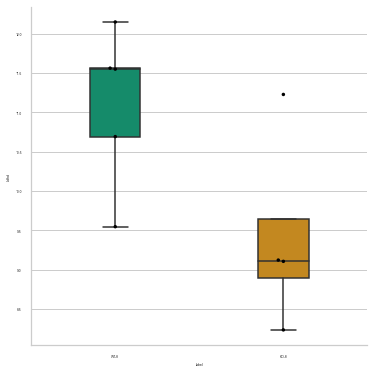

In [65]:
xp.gene_overview(
    data_8wk_norm, 
    meta_8wk, 
    gene_name='Ldhd',
    palette=data_8wk_colors, 
    order=['WT-8','KO-8'],
    save_fig=__path__ + 'plots/LDHD_boxswarm_8wk.pdf', 
    grid=True, 
    whitegrid=True)

<Figure size 432x288 with 0 Axes>

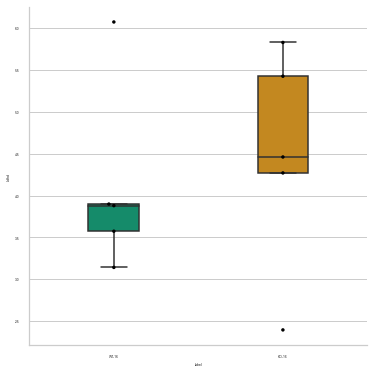

In [66]:
xp.gene_overview(
    data_16wk_norm, 
    meta_16wk, 
    gene_name='Ldhd',
    palette=data_16wk_colors, 
    order=['WT-16','KO-16'],
    save_fig=__path__ + 'plots/LDHD_boxswarm_16wk.pdf', 
    grid=True, 
    whitegrid=True)

In [29]:
for i, r in data_8wk_norm.iterrows():
    if 'ldh' in i.lower():
        print(i)
#data_8wk_norm.loc["Ldhal6b"]

Aldh16a1
Aldh3a2
Aldh1a2
Aldh1l2
Aldh6a1
Aldh18a1
Aldh9a1
Aldh4a1
Aldh2
Ldhb
Ldhd
Aldh1b1
Aldh5a1
Aldh1a1
Aldh7a1
Ldha


In [30]:
data_8wk_norm.loc['Ldha']

15948X11    273.023222
15948X12    246.072605
15948X13    235.354521
15948X14    247.128810
15948X15    223.351070
15948X16    245.263237
15948X17    225.372029
15948X18    242.739703
15948X20    224.337648
Name: Ldha, dtype: float64

In [31]:
data_8wk_norm.loc['Cs']

15948X11    468.869587
15948X12    464.005072
15948X13    452.397020
15948X14    457.138337
15948X15    445.109630
15948X16    434.694000
15948X17    472.914232
15948X18    395.648518
15948X20    428.325509
Name: Cs, dtype: float64

<Figure size 432x288 with 0 Axes>

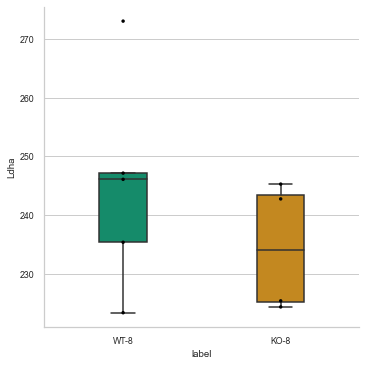

In [36]:
xp.gene_overview(
    data_8wk_norm, 
    meta_8wk, 
    gene_name='Ldha',
    palette=data_8wk_colors, 
    order=['WT-8','KO-8'],
    save_fig=__path__ + 'plots/Ldha_boxswarm_8wk.pdf', 
    grid=True, 
    whitegrid=True)

<Figure size 432x288 with 0 Axes>

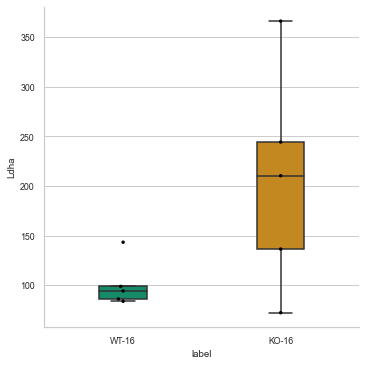

In [37]:
xp.gene_overview(
    data_16wk_norm, 
    meta_16wk, 
    gene_name='Ldha',
    palette=data_16wk_colors, 
    order=['WT-16','KO-16'],
    save_fig=__path__ + 'plots/Ldha_boxswarm_16wk.pdf', 
    grid=True, 
    whitegrid=True)

<Figure size 432x288 with 0 Axes>

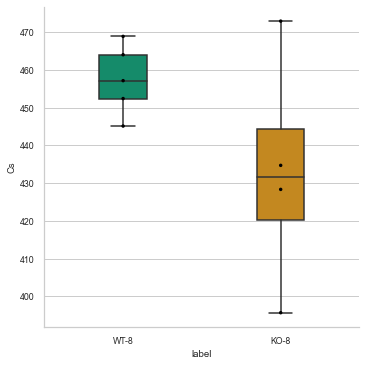

In [38]:
xp.gene_overview(
    data_8wk_norm, 
    meta_8wk, 
    gene_name='Cs',
    palette=data_8wk_colors, 
    order=['WT-8','KO-8'],
    save_fig=__path__ + 'plots/Cs_boxswarm_8wk.pdf', 
    grid=True, 
    whitegrid=True)

<Figure size 432x288 with 0 Axes>

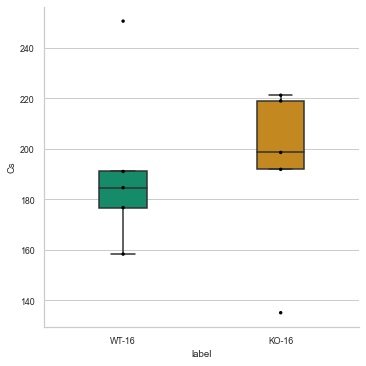

In [39]:
xp.gene_overview(
    data_16wk_norm, 
    meta_16wk, 
    gene_name='Cs',
    palette=data_16wk_colors, 
    order=['WT-16','KO-16'],
    save_fig=__path__ + 'plots/Cs_boxswarm_16wk.pdf', 
    grid=True, 
    whitegrid=True)